In [2]:
import matplotlib
matplotlib.use('pgf')
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib notebook
import tensorflow as tf
import os

import time
import pickle

In [3]:
plt.style.use('ggplot')

In [4]:
matplotlib.rcParams['figure.figsize'] = (6.0, 5.0)

In [5]:
def load_tf_scalar(folder, tag):
    time0 = time.time()

    steps = []
    h = []
    for file in sorted(os.listdir(folder)):
        try:
            for e in tf.train.summary_iterator(folder + file):
                for v in e.summary.value:
                    if v.tag == tag:
                        h.append(v.simple_value)
                        steps.append(e.step)
        except tf.errors.DataLossError:
            print('DataLossError')
            pass
    
    print('Took this many seconds: ', time.time() - time0)
    return steps, h

In [6]:
def load_tb_all(folder):
    time0 = time.time()

    data_dict = {}
    for file in sorted(os.listdir(folder)):
        try:
            for e in tf.train.summary_iterator(folder + file):
                for v in e.summary.value:
                    if v.tag not in data_dict.keys():
                        data_dict[v.tag] = [[], []]
                    data_dict[v.tag][0].append(e.step)
                    data_dict[v.tag][1].append(v.simple_value)
        except tf.errors.DataLossError:
            print('DataLossError')
            pass
    
    print('Took this many seconds: ', time.time() - time0)
    return data_dict

In [8]:
aliases = {"slither-AE-LSTM-final-bl": "baseline feed-forward",
            "slither-AE-LSTM-final-n": "baseline recurrent",
            "slither-AE-LSTM-final-e2e": "main",
            "slither-AE-LSTM-final-act-e2e": "main w. action",
            "slither-AE-LSTM-final-act-e2e-sim": "final w. action",
            "slither-AE-LSTM-final-e2e-c2d": "residual",
            "slither-AE-LSTM-final-e2e-d2d": "residual, error input",
            "slither-AE-LSTM-final-e2e-aim": "closed loop $+$",
            "slither-AE-LSTM-final-e2e-sim": "closed loop $-$",
}


In [13]:
load_ids = ["./tb_final/slither-AE-LSTM-final-act-e2e-sim/",
            "./tb_final/slither-AE-LSTM-final-act-e2e/"
           ]
load_dict = {}

for load_id in load_ids[:]:
    data = load_tb_all(load_id)
    load_dict[load_id.split("/")[2]] = data

DataLossError
DataLossError
Took this many seconds:  69.8958888053894
DataLossError
Took this many seconds:  81.09894061088562


In [7]:
load_ids = ["./tb_final/slither-AE-LSTM-final-bl/",
            "./tb_final/slither-AE-LSTM-final-n/",
            "./tb_final/slither-AE-LSTM-final-e2e/",
            "./tb_final/slither-AE-LSTM-final-e2e-c2d/",
            "./tb_final/slither-AE-LSTM-final-e2e-d2d/",
            "./tb_final/slither-AE-LSTM-final-e2e-aim/",
            "./tb_final/slither-AE-LSTM-final-e2e-sim/",
#             "./tb_final/slither-AE-LSTM-final-e2e-d2d-reg/",
#             "./tb_final/slither-AE-LSTM-final-e2e-aio/"
           ]
load_dict = {}

for load_id in load_ids[:]:
    data = load_tb_all(load_id)
    load_dict[load_id.split("/")[2]] = data

DataLossError
Took this many seconds:  56.74073767662048
DataLossError
DataLossError
Took this many seconds:  73.05494451522827
DataLossError
Took this many seconds:  66.84426212310791
DataLossError
DataLossError
Took this many seconds:  64.2077956199646
Took this many seconds:  63.146400928497314
Took this many seconds:  31.140134811401367
DataLossError
Took this many seconds:  30.428579092025757


In [215]:
pickle.dump(load_dict, open("./tb_final/selection/pickled.pkl", "wb"))

In [213]:
load_dict = pickle.load(open("./tb_final/selection/pickled.pkl", "rb"))

In progress

In [214]:
load_id = "./tb_final/slither-AE-LSTM-final-e2e-aim/"
data = load_tb_all(load_id)
load_dict[load_id.split("/")[2]] = data

load_id = "./tb_final/slither-AE-LSTM-final-e2e-sim/"
data = load_tb_all(load_id)
load_dict[load_id.split("/")[2]] = data

Took this many seconds:  15.139007091522217
DataLossError
Took this many seconds:  16.78554606437683


In [216]:
list(aliases.keys())

['slither-AE-LSTM-final-e2e',
 'slither-AE-LSTM-final-e2e-d2d',
 'slither-AE-LSTM-final-e2e-sim',
 'slither-AE-LSTM-final-bl',
 'slither-AE-LSTM-final-act-e2e',
 'slither-AE-LSTM-final-n',
 'slither-AE-LSTM-final-e2e-aim',
 'slither-AE-LSTM-final-e2e-c2d']

In [14]:
def plot(name_list, tag='loss', pow2smoothing=12, legendloc=1, ylabel="Binary Cross Entropy loss"):
    fig_loss, ax_loss = plt.subplots()

    xfmt = plt.ScalarFormatter()
    xfmt.set_powerlimits((-3,3))

    line_dict = {}

    ax_loss.cla()
    for name in name_list:
        data = load_dict[name]
        steps, h = data[tag]

        window = 2**min(int(math.log(len(h)/4, 2)), pow2smoothing)
        conv_h = np.convolve(h, np.ones(window)/window, mode='valid')
#         alpha = 0.5 if name in ["slither-AE-LSTM-final-n", "slither-AE-LSTM-final-bl"] else 1.0
        line, = ax_loss.plot(steps[len(steps) - len(conv_h):], conv_h, alpha=1.0, label=aliases[name])
        line_dict[name] = line

    # ax_loss.set_xlim(right=1e6)
    ax_loss.xaxis.set_major_formatter(xfmt)

    handles, labels = ax_loss.get_legend_handles_labels()
    import operator
    hl = sorted(zip(handles, labels),
                key=operator.itemgetter(1))
    handles2, labels2 = zip(*hl)
    
    ax_loss.set_xlabel("SGD steps")
    ax_loss.set_ylabel(ylabel)

    ax_loss.legend(handles2, labels2, loc=legendloc)
    
    return fig_loss, ax_loss

In [15]:
matplotlib.rcParams['figure.figsize'] = (6.0, 5.0)

/home/guille/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


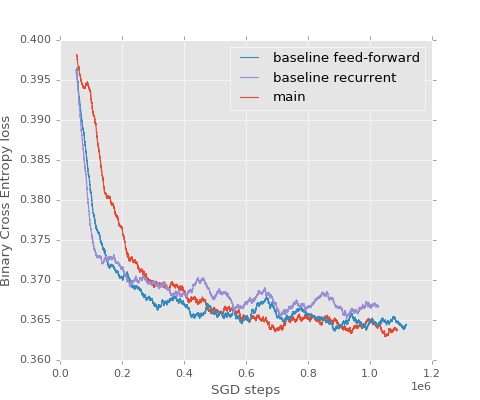

In [236]:
main_and_baselines = ['slither-AE-LSTM-final-e2e',
                     'slither-AE-LSTM-final-bl',
                     'slither-AE-LSTM-final-n']

fig, ax = plot(main_and_baselines)
fig.savefig("./final_figures/loss-main_and_baselines.pdf")

/home/guille/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


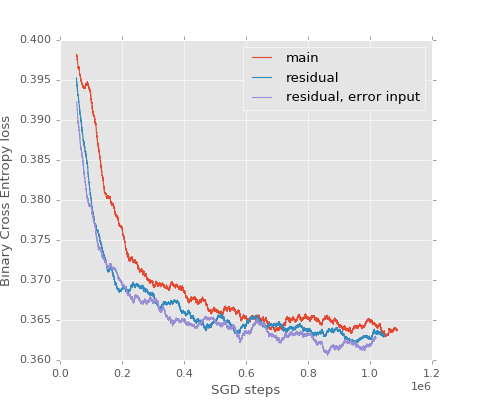

In [237]:
main_and_residuals = ['slither-AE-LSTM-final-e2e',
                     'slither-AE-LSTM-final-e2e-c2d',
                     'slither-AE-LSTM-final-e2e-d2d']

fig, ax = plot(main_and_residuals)
fig.savefig("./final_figures/loss-main_and_residuals.pdf")

/home/guille/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


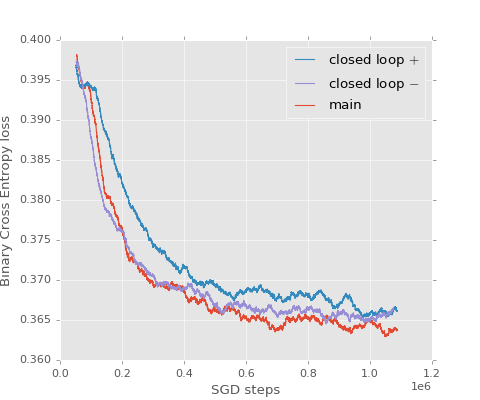

In [238]:
main_and_closedloop = ['slither-AE-LSTM-final-e2e',
                     'slither-AE-LSTM-final-e2e-aim',
                     'slither-AE-LSTM-final-e2e-sim']

fig, ax = plot(main_and_closedloop)
fig.savefig("./final_figures/loss-main_and_closedloop.pdf")

/home/guille/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


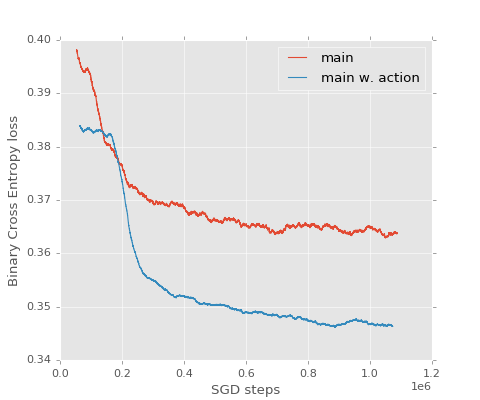

In [239]:
endtoend_and_w_action = ['slither-AE-LSTM-final-e2e',
                     'slither-AE-LSTM-final-act-e2e',
                     ]

fig, ax = plot(endtoend_and_w_action)
fig.savefig("./final_figures/loss-main_w_and_wout_action.pdf")

<IPython.core.display.Javascript object>


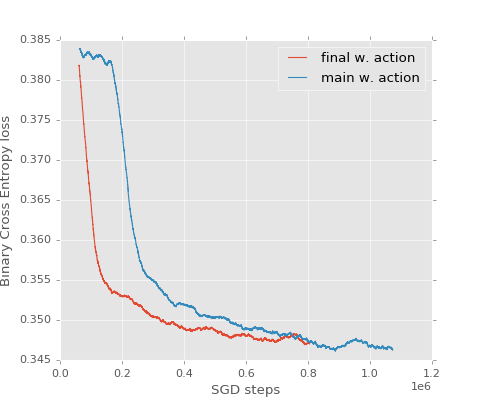

In [16]:
endtoend_and_w_action = ['slither-AE-LSTM-final-act-e2e-sim',
                     'slither-AE-LSTM-final-act-e2e',
                     ]

fig, ax = plot(endtoend_and_w_action)
# fig.savefig("./final_figures/loss-main_w_and_wout_action.pdf")

In [240]:
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

In [241]:
grad_lines = ['slither-AE-LSTM-final-e2e',
              'slither-AE-LSTM-final-e2e-d2d',
              'slither-AE-LSTM-final-e2e-sim',
              'slither-AE-LSTM-final-bl',
              'slither-AE-LSTM-final-n',
              'slither-AE-LSTM-final-e2e-aim',
              'slither-AE-LSTM-final-e2e-c2d']

<IPython.core.display.Javascript object>


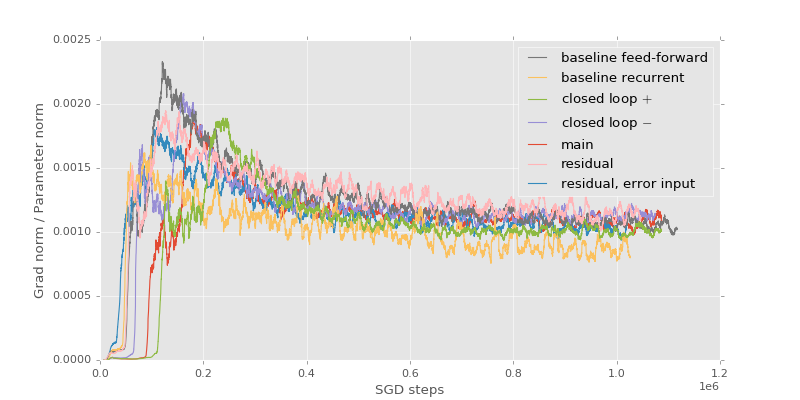

/home/guille/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


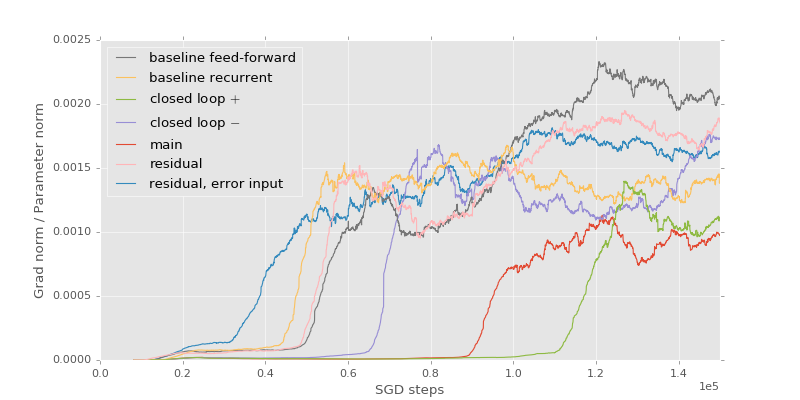

In [242]:
fig0, ax0 = plot(grad_lines, tag='encoder/ratio_6(64, 32, 4, 4)', pow2smoothing=8, ylabel="Grad norm / Parameter norm")
fig1, ax1 = plot(grad_lines, tag='encoder/ratio_6(64, 32, 4, 4)', pow2smoothing=8, legendloc=2, ylabel="Grad norm / Parameter norm")

ax1.set_xlim(right=1.5e5)
fig0.savefig("./final_figures/grad-encoder.pdf")
fig1.savefig("./final_figures/grad-encoder-zoom.pdf")

<IPython.core.display.Javascript object>


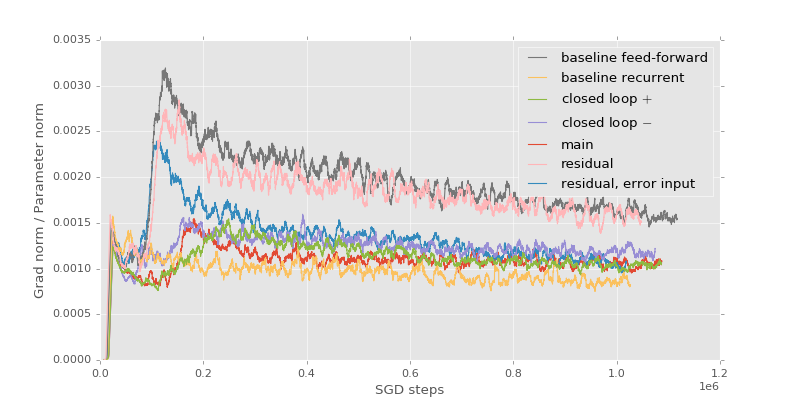

/home/guille/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


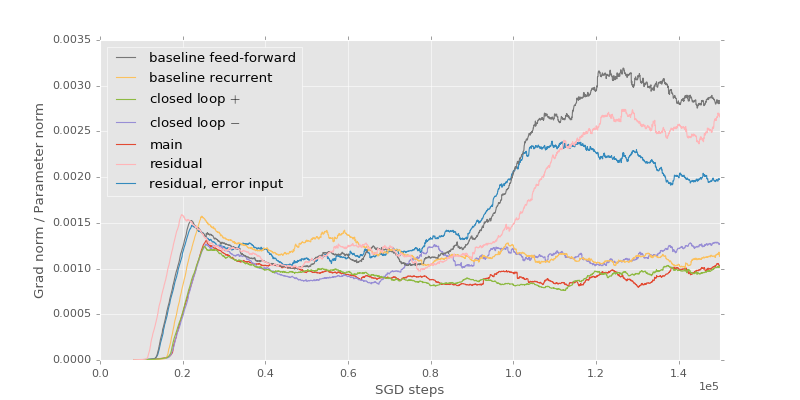

In [243]:
fig0, ax0 = plot(grad_lines, tag='decoder/ratio_4(64, 32, 4, 4)', pow2smoothing=8, ylabel="Grad norm / Parameter norm")
fig1, ax1 = plot(grad_lines, tag='decoder/ratio_4(64, 32, 4, 4)', pow2smoothing=8, legendloc=2, ylabel="Grad norm / Parameter norm")

ax1.set_xlim(right=1.5e5)
fig0.savefig("./final_figures/grad-decoder.pdf")
fig1.savefig("./final_figures/grad-decoder-zoom.pdf")

In [244]:
load_dict['slither-AE-LSTM-final-e2e'].keys()

dict_keys(['decoder/ratio_11(1,)', 'encoder/ratio_2(16, 16, 4, 4)', 'decoder/ratio_3(64,)', 'decoder/ratio_10(16, 1, 4, 4)', 'rnn/ratio_2(2048,)', 'encoder/ratio_10(512, 128, 5, 5)', 'encoder/ratio_3(16,)', 'encoder/ratio_7(64,)', 'loss', 'decoder/ratio_2(128, 64, 4, 4)', 'decoder/ratio_8(16, 16, 4, 4)', 'rnn/ratio_3(2048,)', 'encoder/ratio_0(16, 1, 4, 4)', 'decoder/ratio_9(16,)', 'decoder/ratio_5(32,)', 'decoder/ratio_1(128,)', 'decoder/ratio_6(32, 16, 4, 4)', 'encoder/ratio_9(128,)', 'rnn/ratio_1(2048, 512)', 'rnn/ratio_5(512,)', 'encoder/ratio_11(512,)', 'rnn/ratio_4(512, 512)', 'rnn/ratio_0(2048, 512)', 'decoder/ratio_0(512, 128, 5, 5)', 'decoder/ratio_4(64, 32, 4, 4)', 'encoder/ratio_5(32,)', 'encoder/ratio_6(64, 32, 4, 4)', 'encoder/ratio_8(128, 64, 4, 4)', 'encoder/ratio_4(32, 16, 4, 4)', 'encoder/ratio_1(16,)', 'decoder/ratio_7(16,)'])

In [245]:
import pandas as pd

train_data = pickle.load(open("./final_figures/train_losses.pkl", 'rb'))
test_data = pickle.load(open("./final_figures/test_losses.pkl", 'rb'))

data = []
indexes = []
for k in train_data.keys():
    indexes.append(aliases[k])
    data.append([train_data[k], test_data[k]])

df = pd.DataFrame(data, columns=['train', 'test'], index=indexes)

df = df.sort_index()

In [246]:
matplotlib.rcParams['figure.figsize'] = (6.0, 5.0)

/home/guille/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


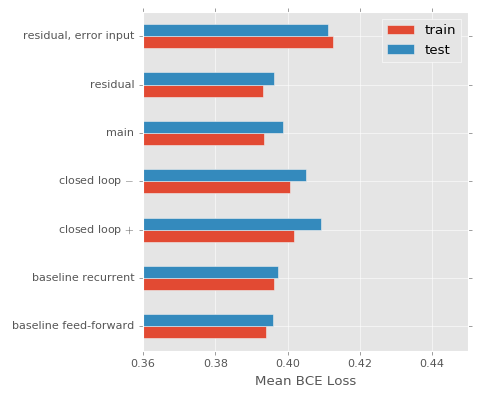

In [247]:
ax = df.plot(kind='barh', xlim=[0.36, None], rot=0)
ax.set_xlabel('Mean BCE Loss')
plt.tight_layout()
plt.savefig('./final_figures/loss-traintest-barh.pdf')

In [248]:
import pandas as pd

code_error_data = pickle.load(open("./final_figures/code_errors.pkl", 'rb'))

data = []
indexes = []
for k in code_error_data.keys():
    indexes.append(aliases[k])
    data.append(code_error_data[k])

df = pd.DataFrame(data, columns=['test'], index=indexes)

df = df.sort_index()

/home/guille/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


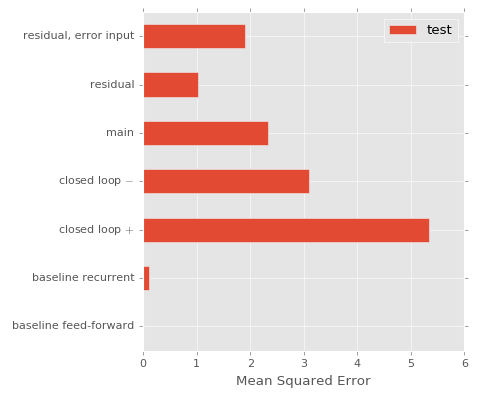

In [249]:
ax = df.plot(kind='barh', rot=0)
ax.set_xlabel('Mean Squared Error')
plt.tight_layout()
plt.savefig('./final_figures/code_errors.pdf')